In [36]:
from sem.generate_series import create_sde_process
from sem.sem.mixture_sem import MixtureSEM
from sem.sem.mixture_em_diff import NormalMixtureEM
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep
import torch
import numpy as np
import random

seed = 45
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
random.seed(seed)



num_components = 5
length = 4000

series_dct = create_sde_process(length, n_components=num_components)
series = series_dct['X']
deltas = series[1:] - series[:-1]
a_trafaret = series_dct['a_t']
b_trafaret = series_dct['b_t']
# plt.plot(series)
# plt.title('X(t)')
# plt.show()
# plt.plot(deltas)
# plt.title('dX(t)')
# plt.show()
# plt.plot(a_trafaret)
# plt.title('a(t)')
# plt.show()
# plt.plot(b_trafaret)
# plt.title('b(t)')
# plt.show()

In [45]:
sem = MixtureSEM(deltas, 'exp', n_components=2, N_init=5, alpha=0.8, comp_distr='laplace', exp_smooth=0.8, prior_strength=1.0, tol=1e-4, device="cuda")
args = sem.find_params()

g = args['g']
a_k = args['mu']
b_k = args['sigma']
p_k = args['w']
nu = None
if 'nu' in args:
    nu = args['nu']

p_values = torch.tensor([0.5], dtype=torch.float32, device=g.device)

median = sem.batched_mixture_multiple_percentiles(p_k, p_values, g=g, mu=a_k, sigma=b_k, nu=nu).squeeze().cpu()

mode = sem.batched_mixture_mode(g=g, w=p_k, mu=a_k, sigma=b_k, nu=nu).squeeze().cpu()

a_k = args['mu'].squeeze().cpu()
b_k = args['sigma'].squeeze().cpu()
p_k = args['w'].squeeze().cpu()

mean = torch.sum((p_k * a_k), 1).cpu()

N = 5; Max ACF(1): 1.0
N = 10; Max ACF(1): 0.9496883153915405
N = 15; Max ACF(1): 0.9017770290374756
N = 20; Max ACF(1): 0.843960702419281
N = 25; Max ACF(1): 0.8277676701545715
N = 30; Max ACF(1): 0.7917792797088623
Found window length: 30


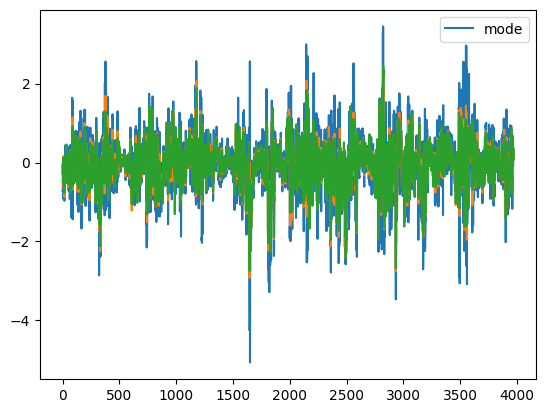

In [46]:
plt.plot(mode.cpu(), label='mode')
plt.plot(median.cpu())
plt.plot(mean)
plt.legend()
plt.show()
# На графике видно, что мода всегда перестреливает медиану

In [47]:
x_modal = torch.cumsum(mode, 0) + series[sem.series_length]
x_median = torch.cumsum(median, 0) + series[sem.series_length]
x_mean = torch.cumsum(torch.sum((p_k * a_k), 1), 0) + series[sem.series_length]

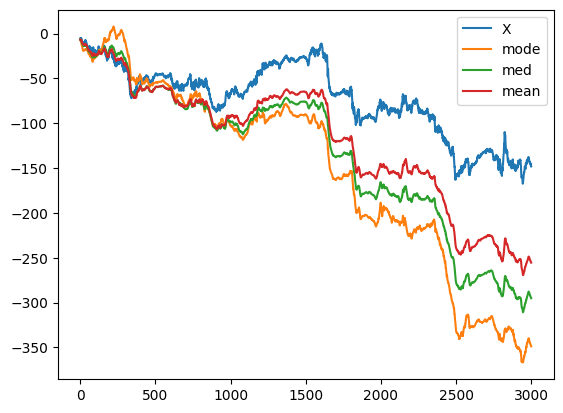

In [48]:
start = 0
finish = 3000
plt.plot(series[sem.series_length + start: sem.series_length + finish], label='X')
plt.plot(x_modal[start: finish], label='mode')
plt.plot(x_median[start: finish], label='med')
plt.plot(x_mean[start: finish], label='mean')
plt.legend()
plt.show()


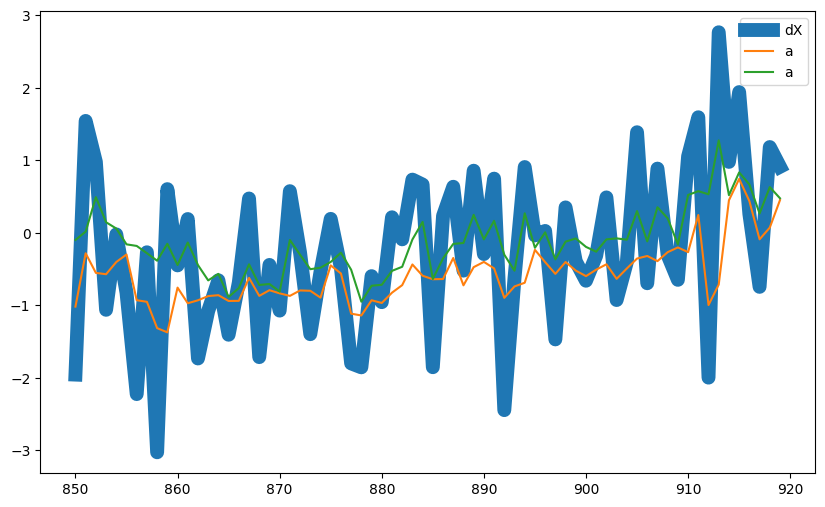

In [12]:
plt.figure(figsize=(10, 6))
start = 850
finish = 920
plt.plot(range(start, finish), deltas[sem.series_length-1 + start:sem.series_length-1 + finish], label='dX', linewidth=10)
plt.plot(range(start, finish), a_k[start:finish], label="a")
plt.legend()
plt.show()

In [13]:
p_k[start: finish], a_k[start: finish], mode[start: finish]

(tensor([[0.6659, 0.3341],
         [0.4017, 0.5983],
         [0.3295, 0.6705],
         [0.4577, 0.5423],
         [0.3736, 0.6264],
         [0.7641, 0.2359],
         [0.7492, 0.2508],
         [0.3630, 0.6370],
         [0.7583, 0.2417],
         [0.3860, 0.6140],
         [0.4747, 0.5253],
         [0.3222, 0.6778],
         [0.6317, 0.3683],
         [0.7740, 0.2260],
         [0.7237, 0.2763],
         [0.3790, 0.6210],
         [0.4973, 0.5027],
         [0.2815, 0.7185],
         [0.6698, 0.3302],
         [0.3030, 0.6970],
         [0.7099, 0.2901],
         [0.4944, 0.5056],
         [0.3201, 0.6799],
         [0.6075, 0.3925],
         [0.3794, 0.6206],
         [0.3882, 0.6118],
         [0.6381, 0.3619],
         [0.5052, 0.4948],
         [0.5395, 0.4605],
         [0.7658, 0.2342],
         [0.5455, 0.4545],
         [0.2600, 0.7400],
         [0.2334, 0.7666],
         [0.4670, 0.5330],
         [0.3639, 0.6361],
         [0.6951, 0.3049],
         [0.2264, 0.7736],
 

In [11]:
%matplotlib inline

window_size = 100

for i in range(0, 100000 - window_size, 4):
    clear_output(wait=True)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(i, i+window_size), deltas[sem.series_length-1 + i:sem.series_length-1 + i + window_size], label='X')
    plt.plot(range(i, i+window_size), a_k.cpu()[i:i+window_size], label="0.50 персентиль")
    plt.legend()
    plt.show()
    sleep(0.5)

KeyboardInterrupt: 

N = 5; Max ACF(1): 0.9999999403953552
N = 10; Max ACF(1): 0.9675994515419006
N = 15; Max ACF(1): 0.9229303598403931
N = 20; Max ACF(1): 0.909864068031311
N = 25; Max ACF(1): 0.8780659437179565
N = 30; Max ACF(1): 0.8668965697288513
N = 35; Max ACF(1): 0.860132098197937
N = 40; Max ACF(1): 0.8530821800231934
N = 45; Max ACF(1): 0.847168505191803
N = 50; Max ACF(1): 0.8394033908843994
N = 55; Max ACF(1): 0.8399832844734192
N = 60; Max ACF(1): 0.8218846917152405
N = 65; Max ACF(1): 0.8199627995491028
N = 70; Max ACF(1): 0.8119117617607117
N = 75; Max ACF(1): 0.809200644493103
N = 80; Max ACF(1): 0.8117722868919373
N = 85; Max ACF(1): 0.8074469566345215
N = 90; Max ACF(1): 0.8019543886184692
N = 95; Max ACF(1): 0.7929076552391052
Found window length: 95
TESTING BATCHED MIXTURE MODE FUNCTION

Testing NORMAL distribution

Test 1: Symmetric 2-component mixture
  Mode found: -2.000000
  Gradient at mode: 0.000000 (should be near 0)
  ✓ Gradient magnitude: 0.000000

Test 2: Asymmetric 2-compone

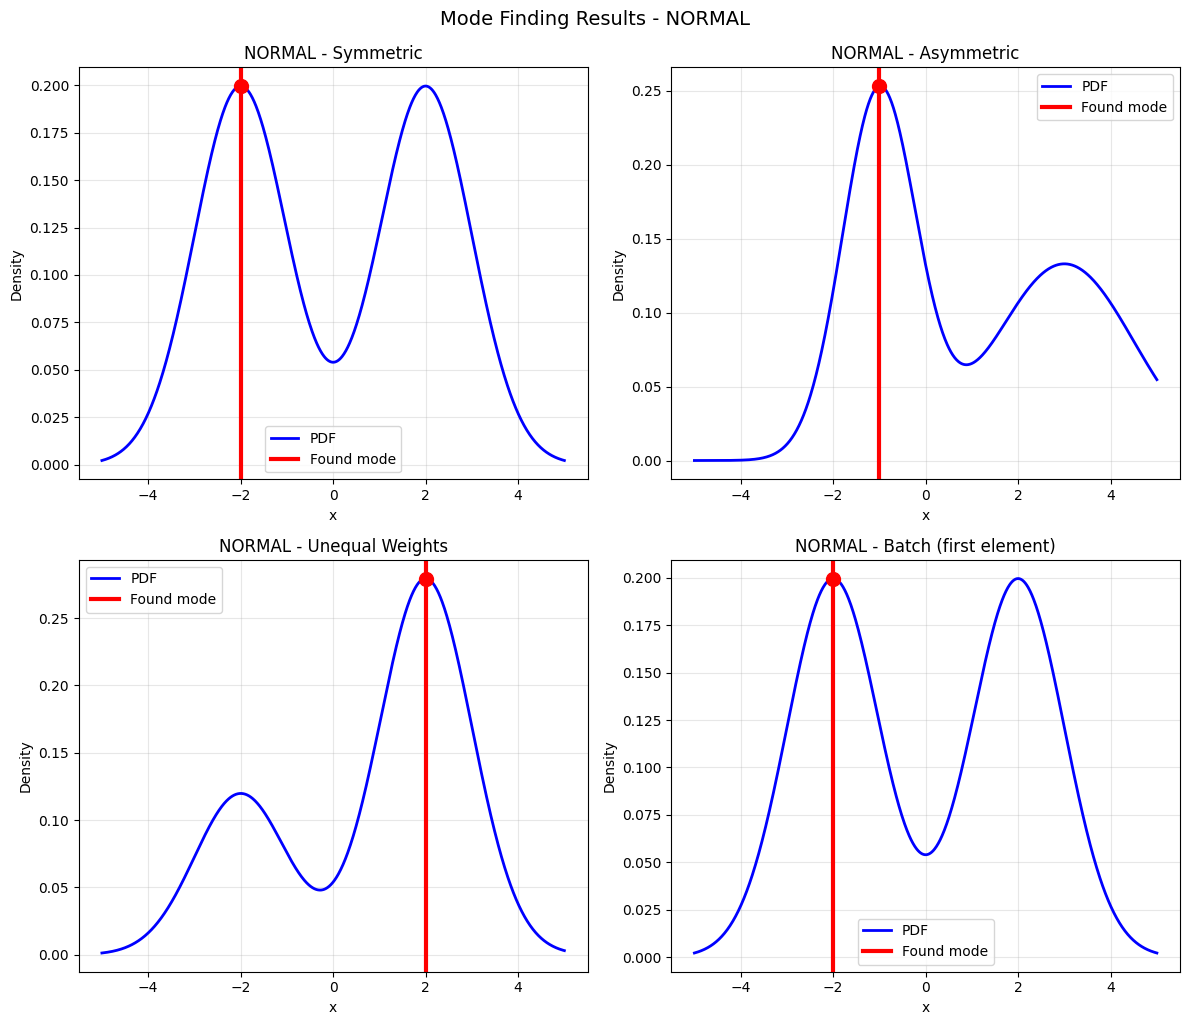


Testing LAPLACE distribution

Test 1: Symmetric 2-component mixture
  Mode found: -2.000000
  Gradient at mode: 0.000000 (should be near 0)
  ✓ Gradient magnitude: 0.000000

Test 2: Asymmetric 2-component mixture
  Mode found: -1.000003
  Gradient at mode: -0.074506

Test 3: Unequal weights
  Mode found: 2.000000
  Gradient at mode: 0.000000

Test 4: Batch processing (2 batches)
  Batch modes: [-2.0, 3.000088691711426]
  Batch shape: torch.Size([2, 1, 1])


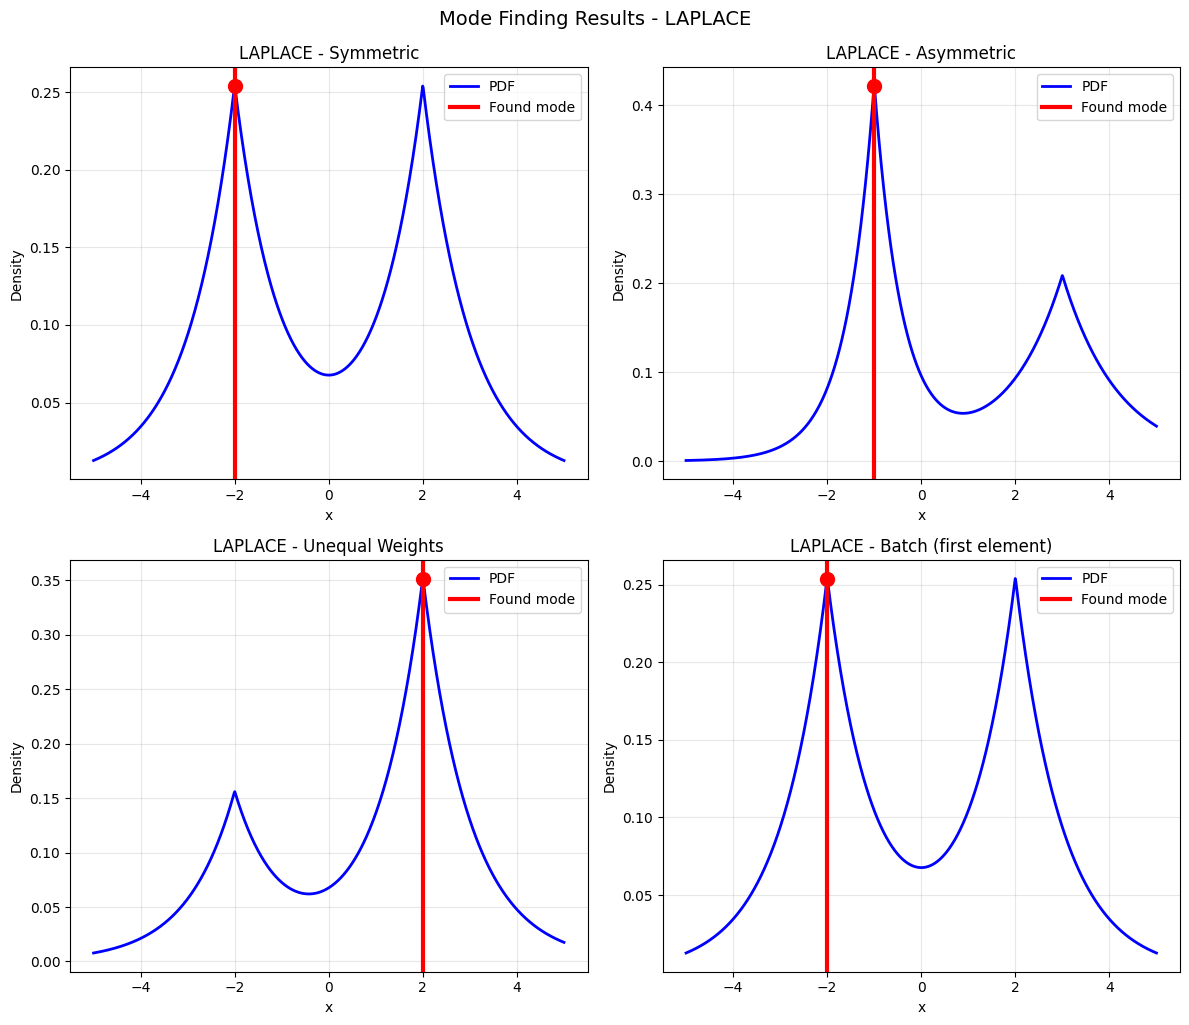


Testing LOGISTIC distribution

Test 1: Symmetric 2-component mixture
  Mode found: -1.999900
  Gradient at mode: 0.000000 (should be near 0)
  ✓ Gradient magnitude: 0.000000

Test 2: Asymmetric 2-component mixture
  Mode found: -1.000000
  Gradient at mode: 0.000000

Test 3: Unequal weights
  Mode found: 2.000000
  Gradient at mode: -0.022352

Test 4: Batch processing (2 batches)
  Batch modes: [-1.999899983406067, -0.9993999004364014]
  Batch shape: torch.Size([2, 1, 1])


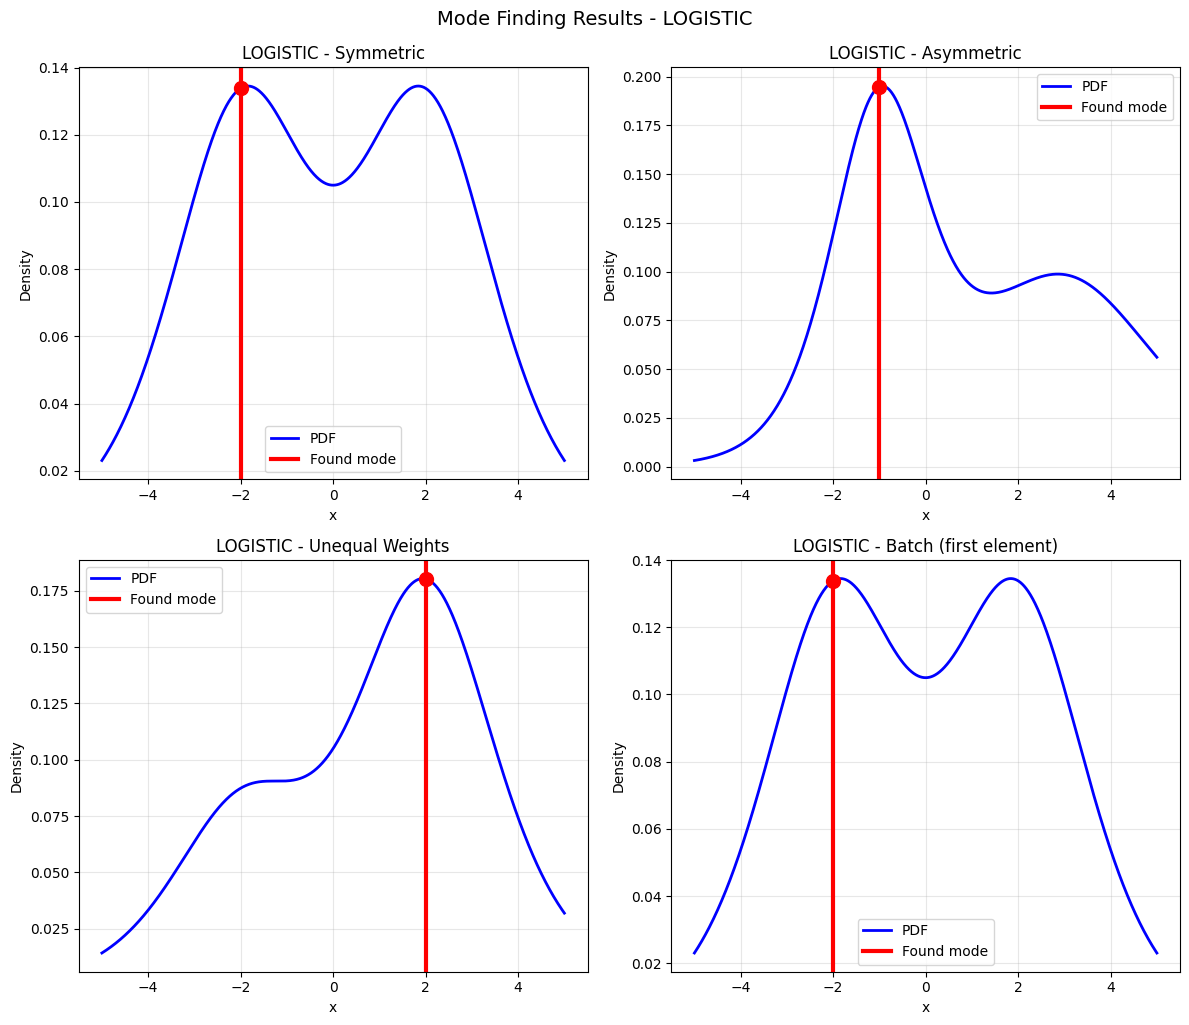


Testing STUDENT distribution

Test 1: Symmetric 2-component mixture
  Mode found: -2.000000
  Gradient at mode: 0.000000 (should be near 0)
  ✓ Gradient magnitude: 0.000000

Test 2: Asymmetric 2-component mixture
  Mode found: -1.000000
  Gradient at mode: -0.085682

Test 3: Unequal weights
  Mode found: 2.000000
  Gradient at mode: 0.000000

Test 4: Batch processing (2 batches)
  Batch modes: [-2.0, 3.0]
  Batch shape: torch.Size([2, 1, 1])


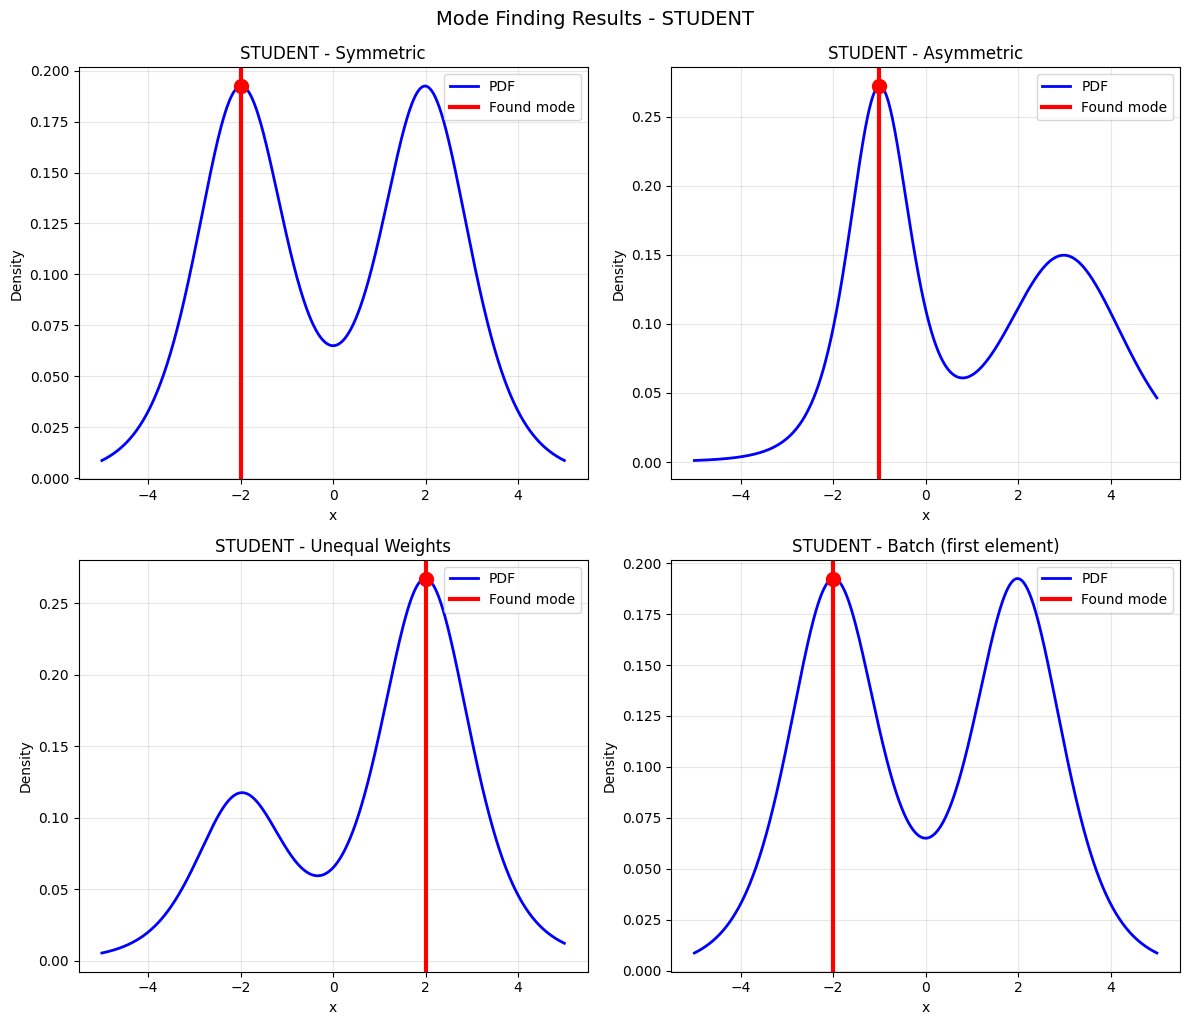


SUMMARY

NORMAL:
  Symmetric mode: -2.0000 (grad: 0.000000)
  Asymmetric mode: -1.0000 (grad: -0.119209)
  Unequal weights mode: 2.0000 (grad: 0.000000)
  ⚠ Some gradients large (max: 0.119209)

LAPLACE:
  Symmetric mode: -2.0000 (grad: 0.000000)
  Asymmetric mode: -1.0000 (grad: -0.074506)
  Unequal weights mode: 2.0000 (grad: 0.000000)
  ⚠ Some gradients large (max: 0.074506)

LOGISTIC:
  Symmetric mode: -1.9999 (grad: 0.000000)
  Asymmetric mode: -1.0000 (grad: 0.000000)
  Unequal weights mode: 2.0000 (grad: -0.022352)
  ⚠ Some gradients large (max: 0.022352)

STUDENT:
  Symmetric mode: -2.0000 (grad: 0.000000)
  Asymmetric mode: -1.0000 (grad: -0.085682)
  Unequal weights mode: 2.0000 (grad: 0.000000)
  ⚠ Some gradients large (max: 0.085682)


{'normal': {'symmetric': (-2.0, 0.0),
  'asymmetric': (-1.0, -0.11920928955078125),
  'unequal_weights': (2.0, 0.0)},
 'laplace': {'symmetric': (-2.0, 0.0),
  'asymmetric': (-1.0000027418136597, -0.07450580596923828),
  'unequal_weights': (2.0, 0.0)},
 'logistic': {'symmetric': (-1.999899983406067, 0.0),
  'asymmetric': (-1.0, 0.0),
  'unequal_weights': (2.0, -0.022351741790771484)},
 'student': {'symmetric': (-2.0, 0.0),
  'asymmetric': (-1.0, -0.08568167686462402),
  'unequal_weights': (2.0, 0.0)}}

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch


def test_batched_mixture_mode(model, distributions=None, plot=True):
    """
    Comprehensive test for batched_mixture_mode function
    
    Tests:
    1. Mode should be at peak of PDF
    2. Gradient should be near zero at mode
    3. Works for different distributions
    4. Works for different component configurations
    """
    if distributions is None:
        distributions = ['normal', 'laplace', 'logistic', 'student']
    
    results = {}
    
    for dist in distributions:
        print(f"\n{'='*50}")
        print(f"Testing {dist.upper()} distribution")
        print('='*50)
        
        # Set the appropriate log_pdf function
        if dist == 'normal':
            model._log_pdf = model.log_pdf_normal
        elif dist == 'laplace':
            model._log_pdf = model.log_pdf_laplace
        elif dist == 'logistic':
            model._log_pdf = model.log_pdf_logistic
        elif dist == 'student':
            model._log_pdf = model.log_pdf_student
        
        # Test Case 1: Simple 2-component mixture (symmetric)
        print("\nTest 1: Symmetric 2-component mixture")
        w1 = torch.tensor([[0.5, 0.5]], device='cpu').unsqueeze(1)
        
        if dist == 'normal':
            args1 = {
                'mu': torch.tensor([[-2.0, 2.0]], device='cpu').unsqueeze(1),
                'sigma': torch.tensor([[1.0, 1.0]], device='cpu').unsqueeze(1)
            }
        elif dist == 'laplace':
            args1 = {
                'mu': torch.tensor([[-2.0, 2.0]], device='cpu').unsqueeze(1),
                'sigma': torch.tensor([[1.0, 1.0]], device='cpu').unsqueeze(1)
            }
        elif dist == 'logistic':
            args1 = {
                'mu': torch.tensor([[-2.0, 2.0]], device='cpu').unsqueeze(1),
                'sigma': torch.tensor([[1.0, 1.0]], device='cpu').unsqueeze(1)
            }
        elif dist == 'student':
            args1 = {
                'mu': torch.tensor([[-2.0, 2.0]], device='cpu').unsqueeze(1),
                'sigma': torch.tensor([[1.0, 1.0]], device='cpu').unsqueeze(1),
                'nu': torch.tensor([[5.0, 5.0]], device='cpu').unsqueeze(1)
            }
        
        mode1 = model.batched_mixture_mode(w1, **args1)
        
        # Verify with gradient
        def compute_gradient(x):
            eps = 1e-6
            x_plus = x + eps
            x_minus = x - eps
            
            log_density_plus = model._log_pdf(x_plus.expand(-1, -1, model.n_components), **args1)
            log_mixture_plus = torch.log(w1 + 1e-8) + log_density_plus
            density_plus = torch.exp(torch.logsumexp(log_mixture_plus, dim=-1, keepdim=True))
            
            log_density_minus = model._log_pdf(x_minus.expand(-1, -1, model.n_components), **args1)
            log_mixture_minus = torch.log(w1 + 1e-8) + log_density_minus
            density_minus = torch.exp(torch.logsumexp(log_mixture_minus, dim=-1, keepdim=True))
            
            return (density_plus - density_minus) / (2 * eps)
        
        grad_at_mode = compute_gradient(mode1)
        
        print(f"  Mode found: {mode1.item():.6f}")
        print(f"  Gradient at mode: {grad_at_mode.item():.6f} (should be near 0)")
        print(f"  ✓ Gradient magnitude: {abs(grad_at_mode.item()):.6f}")
        
        # Test Case 2: Asymmetric mixture
        print("\nTest 2: Asymmetric 2-component mixture")
        
        if dist == 'normal':
            args2 = {
                'mu': torch.tensor([[-1.0, 3.0]], device='cpu').unsqueeze(1),
                'sigma': torch.tensor([[0.8, 1.5]], device='cpu').unsqueeze(1)
            }
        elif dist == 'laplace':
            args2 = {
                'mu': torch.tensor([[-1.0, 3.0]], device='cpu').unsqueeze(1),
                'sigma': torch.tensor([[0.6, 1.2]], device='cpu').unsqueeze(1)
            }
        elif dist == 'logistic':
            args2 = {
                'mu': torch.tensor([[-1.0, 3.0]], device='cpu').unsqueeze(1),
                'sigma': torch.tensor([[0.7, 1.3]], device='cpu').unsqueeze(1)
            }
        elif dist == 'student':
            args2 = {
                'mu': torch.tensor([[-1.0, 3.0]], device='cpu').unsqueeze(1),
                'sigma': torch.tensor([[0.7, 1.3]], device='cpu').unsqueeze(1),
                'nu': torch.tensor([[4.0, 8.0]], device='cpu').unsqueeze(1)
            }
        
        mode2 = model.batched_mixture_mode(w1, **args2)
        grad_at_mode2 = compute_gradient(mode2)
        
        print(f"  Mode found: {mode2.item():.6f}")
        print(f"  Gradient at mode: {grad_at_mode2.item():.6f}")
        
        # Test Case 3: Unequal weights
        print("\nTest 3: Unequal weights")
        w3 = torch.tensor([[0.3, 0.7]], device='cpu').unsqueeze(1)
        
        if dist == 'normal':
            args3 = {
                'mu': torch.tensor([[-2.0, 2.0]], device='cpu').unsqueeze(1),
                'sigma': torch.tensor([[1.0, 1.0]], device='cpu').unsqueeze(1)
            }
        elif dist == 'laplace':
            args3 = {
                'mu': torch.tensor([[-2.0, 2.0]], device='cpu').unsqueeze(1),
                'sigma': torch.tensor([[1.0, 1.0]], device='cpu').unsqueeze(1)
            }
        elif dist == 'logistic':
            args3 = {
                'mu': torch.tensor([[-2.0, 2.0]], device='cpu').unsqueeze(1),
                'sigma': torch.tensor([[1.0, 1.0]], device='cpu').unsqueeze(1)
            }
        elif dist == 'student':
            args3 = {
                'mu': torch.tensor([[-2.0, 2.0]], device='cpu').unsqueeze(1),
                'sigma': torch.tensor([[1.0, 1.0]], device='cpu').unsqueeze(1),
                'nu': torch.tensor([[5.0, 5.0]], device='cpu').unsqueeze(1)
            }
        
        mode3 = model.batched_mixture_mode(w3, **args3)
        grad_at_mode3 = compute_gradient(mode3)
        
        print(f"  Mode found: {mode3.item():.6f}")
        print(f"  Gradient at mode: {grad_at_mode3.item():.6f}")
        
        # Store results
        results[dist] = {
            'symmetric': (mode1.item(), grad_at_mode.item()),
            'asymmetric': (mode2.item(), grad_at_mode2.item()),
            'unequal_weights': (mode3.item(), grad_at_mode3.item())
        }
        
        # Test Case 4: Batch processing
        print("\nTest 4: Batch processing (2 batches)")
        w_batch = torch.tensor([[0.5, 0.5], [0.3, 0.7]], device='cpu').unsqueeze(1)
        
        if dist == 'normal':
            mu_batch = torch.tensor([[-2.0, 2.0], [-1.0, 3.0]], device='cpu').unsqueeze(1)
            sigma_batch = torch.tensor([[1.0, 1.0], [0.8, 1.5]], device='cpu').unsqueeze(1)
            args_batch = {'mu': mu_batch, 'sigma': sigma_batch}
        elif dist == 'student':
            mu_batch = torch.tensor([[-2.0, 2.0], [-1.0, 3.0]], device='cpu').unsqueeze(1)
            sigma_batch = torch.tensor([[1.0, 1.0], [0.8, 1.5]], device='cpu').unsqueeze(1)
            nu_batch = torch.tensor([[5.0, 5.0], [4.0, 8.0]], device='cpu').unsqueeze(1)
            args_batch = {'mu': mu_batch, 'sigma': sigma_batch, 'nu': nu_batch}
        else:
            mu_batch = torch.tensor([[-2.0, 2.0], [-1.0, 3.0]], device='cpu').unsqueeze(1)
            sigma_batch = torch.tensor([[1.0, 1.0], [0.8, 1.5]], device='cpu').unsqueeze(1)
            args_batch = {'mu': mu_batch, 'sigma': sigma_batch}
        
        modes_batch = model.batched_mixture_mode(w_batch, **args_batch)
        print(f"  Batch modes: {modes_batch.squeeze().tolist()}")
        print(f"  Batch shape: {modes_batch.shape}")
        
        # Visualization
        if plot:
            fig, axes = plt.subplots(2, 2, figsize=(12, 10))
            axes = axes.flatten()
            
            test_cases = [
                (w1, args1, "Symmetric", 0),
                (w1, args2, "Asymmetric", 1),
                (w3, args3, "Unequal Weights", 2),
                (w_batch, args_batch, "Batch (first element)", 3)
            ]
            
            for test_w, test_args, title, idx in test_cases:
                ax = axes[idx]
                
                # Generate x values
                if idx < 3:
                    left_bound = -5
                    right_bound = 5
                else:
                    # For batch, use first batch element
                    left_bound = -5
                    right_bound = 5
                
                x_vals = torch.linspace(left_bound, right_bound, 1000, device='cpu').view(1, -1, 1)
                
                # Compute density
                if idx < 3:
                    log_density = model._log_pdf(x_vals.expand(-1, -1, model.n_components), **test_args)
                    log_mixture = torch.log(test_w + 1e-8) + log_density
                else:
                    # For batch, use first element
                    w_first = test_w[0:1]
                    args_first = {k: v[0:1] for k, v in test_args.items()}
                    log_density = model._log_pdf(x_vals.expand(-1, -1, model.n_components), **args_first)
                    log_mixture = torch.log(w_first + 1e-8) + log_density
                
                density = torch.exp(torch.logsumexp(log_mixture, dim=-1)).detach().numpy().flatten()
                x_np = x_vals.squeeze().numpy()
                
                # Plot
                ax.plot(x_np, density, 'b-', linewidth=2, label='PDF')
                
                # Mark mode
                if idx < 3:
                    mode_val = [mode1, mode2, mode3][idx].item()
                    ax.axvline(mode_val, color='r', linewidth=3, label='Found mode')
                    ax.scatter([mode_val], [density[np.argmin(np.abs(x_np - mode_val))]], 
                              color='red', s=100, zorder=5)
                else:
                    mode_val = modes_batch[0].item()
                    ax.axvline(mode_val, color='r', linewidth=3, label='Found mode')
                    ax.scatter([mode_val], [density[np.argmin(np.abs(x_np - mode_val))]], 
                              color='red', s=100, zorder=5)
                
                ax.set_title(f'{dist.upper()} - {title}')
                ax.set_xlabel('x')
                ax.set_ylabel('Density')
                ax.legend()
                ax.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.suptitle(f'Mode Finding Results - {dist.upper()}', y=1.02, fontsize=14)
            plt.show()
    
    return results

# Run all tests
def run_mode_tests(model):
    """Run comprehensive mode tests"""
    print("="*60)
    print("TESTING BATCHED MIXTURE MODE FUNCTION")
    print("="*60)
    
    results = test_batched_mixture_mode(model, plot=True)
    
    # Summary
    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    
    for dist, tests in results.items():
        print(f"\n{dist.upper()}:")
        sym_mode, sym_grad = tests['symmetric']
        asym_mode, asym_grad = tests['asymmetric']
        weight_mode, weight_grad = tests['unequal_weights']
        
        print(f"  Symmetric mode: {sym_mode:.4f} (grad: {sym_grad:.6f})")
        print(f"  Asymmetric mode: {asym_mode:.4f} (grad: {asym_grad:.6f})")
        print(f"  Unequal weights mode: {weight_mode:.4f} (grad: {weight_grad:.6f})")
        
        # Check if gradients are near zero
        all_grads = [sym_grad, asym_grad, weight_grad]
        max_grad = max(abs(g) for g in all_grads)
        if max_grad < 1e-3:
            print(f"  ✓ All gradients near zero (max: {max_grad:.6f})")
        else:
            print(f"  ⚠ Some gradients large (max: {max_grad:.6f})")
    
    return results

# Example usage:
# model = YourModelClass(...)
# results = run_mode_tests(model)
model = MixtureSEM(deltas, 'exp', n_components=2, N_init=5, alpha=0.8, 
                   comp_distr='normal', exp_smooth=0.8, prior_strength=1.0, 
                   tol=1e-4, device="cpu")
run_mode_tests(model)